In [2]:
import numpy as np
import pathlib
import os
import PIL
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

from images_aux import *


In [3]:
# Paths to data
data_url = 'example_images/paintings_sub/'
data_dir = pathlib.Path(data_url)

save_url = 'created_images/'

# Lets see our number of samples
train_image_count = len(list(data_dir.glob('*/*.*')))
print("Items in directory:",train_image_count)

Items in directory: 3336


In [4]:
batch_size = 16
img_height = 500
img_width = 500

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  crop_to_aspect_ratio=True,
  batch_size=batch_size)

Found 3336 files belonging to 18 classes.
Using 2669 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  crop_to_aspect_ratio=True,
  batch_size=batch_size)

Found 3336 files belonging to 18 classes.
Using 667 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['Alfred_Sisley', 'Camille_Pissarro', 'Caravaggio', 'Claude_Monet', 'Edgar_Degas', 'El_Greco', 'Georges_Seurat', 'Henri_Matisse', 'Henri_Rousseau', 'Leonardo_da_Vinci', 'Pablo_Picasso', 'Paul_Gauguin', 'Paul_Klee', 'Pieter_Bruegel', 'Rembrandt', 'Salvador_Dali', 'Vasiliy_Kandinskiy', 'William_Turner']


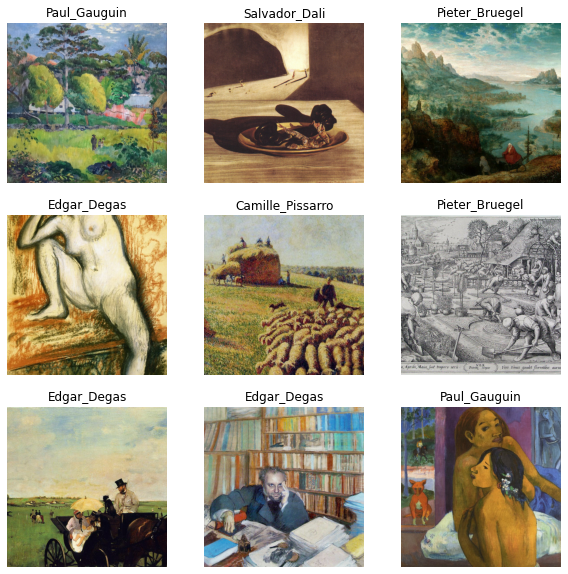

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 500, 500, 3)
(16,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
num_classes = len(class_names)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

model = tf.keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callback]
)

Epoch 1/100
167/167 [==============================] - 21s 122ms/step - loss: 2.4879 - accuracy: 0.2746 - val_loss: 2.3222 - val_accuracy: 0.3208
Epoch 2/100
167/167 [==============================] - 20s 120ms/step - loss: 2.1277 - accuracy: 0.3672 - val_loss: 2.0634 - val_accuracy: 0.3733
Epoch 3/100
167/167 [==============================] - 20s 121ms/step - loss: 1.9195 - accuracy: 0.4211 - val_loss: 1.8556 - val_accuracy: 0.4378
Epoch 4/100
167/167 [==============================] - 20s 117ms/step - loss: 1.8206 - accuracy: 0.4496 - val_loss: 1.8124 - val_accuracy: 0.4618
Epoch 5/100
167/167 [==============================] - 20s 117ms/step - loss: 1.7244 - accuracy: 0.4713 - val_loss: 1.7528 - val_accuracy: 0.4468
Epoch 6/100
167/167 [==============================] - 20s 117ms/step - loss: 1.6887 - accuracy: 0.4743 - val_loss: 1.7204 - val_accuracy: 0.4843
Epoch 7/100
167/167 [==============================] - 20s 117ms/step - loss: 1.6026 - accuracy: 0.5114 - val_loss: 1.8249 -

In [18]:
model.layers